# Section 1: Business Understanding

&ensp;  This is the first Udacity Data Science Nano degree project. For this project, I picked the Boston Airbnb dataset(listings.csv) to understand which listing attributes/factors affect Airbnb hosts' bookings:
<br> &ensp;  Question #2: What are the top five influential listing factors/attributes in the Boston market (the other two questions are written separately in other two notebooks)
<br> &ensp;  The method for figuring out the top five listing factors is presented in the following general steps:
<br> &ensp;  1. Calculate the correlation coefficients between all attributes and listing price
<br> &ensp;  2. Rank all coefficients from high to low and select the top five ones
<br> &ensp;  3. Plug the five attributes to build a linear regression model 
<br> &ensp;  4. Split the data into training and testing data set by 7 to 3 ratio
<br> &ensp;  5. Calculate R-square value to validate the fitness of the selected attributes for the trained linear model

In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Section 2: Data Understanding

&ensp;  After load data into f_attr variable, we find out there are in total 94 attributes including output variable price. There are mixed types of attributes. There are total 3584 records and some of records with missing value in different columns/attributes. In the next section, we have a lot of data cleansing work needed to finish including data type conversion, irrelevant data removal, and fixing the missing data issues. 

In [21]:
#load data to dataframe called f_attr
f_attr=pd.read_csv(r'/Users/zhosheng/Desktop/Study/DS_Udacity_Projects/Boston/listings.csv')

#review data
f_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

# Section 3: Data Preparation

#### Output variable missing/null value handling and data type conversion
&ensp;  To better run the linear model in the later section, I decide not to fill the missing value by average or median values since there are not too many missing price values. Simply dropping them is the way to handle it.
<br> &ensp;  After missing values are removed, the next step is to convert the price variable from object to float so that later I can run correlation coefficient analysis.

In [22]:
#remove null value on "price" field
f_attr=f_attr.dropna(subset=['price'])

#since the original data type in "price" field is string type, it has to be converted to float for further analysis
f_attr['price']=f_attr['price'].str.replace('$','')
f_attr['price']=f_attr['price'].str.replace(',','')
f_attr['price']=f_attr['price'].astype(str).astype(float)

#### Output variable outlier handling
&ensp; After handling missing value and converting to float type for price, next step is to deal with the outlier issue. As you might notice the box plot below, the price data distribution is largely stretched to the upper end. The method is to calculate the mean and standard deviation of price in the refined data set; then normalize each individual price by giving a Z score. Any price that is more than 1 standard deviation away from the mean will be considered as outlier and get removed from the data set.

<AxesSubplot:>

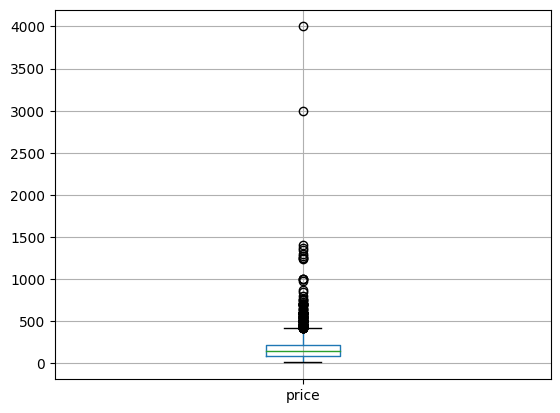

In [23]:
#before remove price outliers, what data distribution looks like
f_attr.boxplot(column=['price'])

<AxesSubplot:>

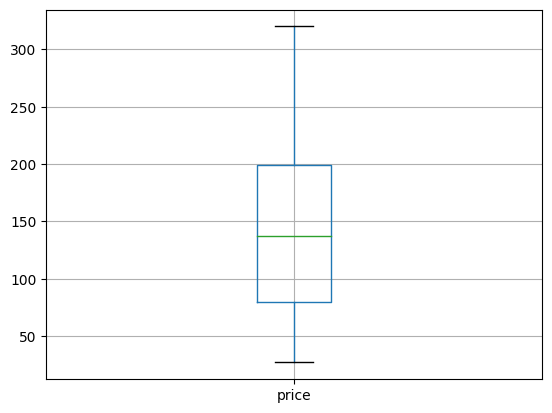

In [24]:
#calculate mean of price in the data set
avg=f_attr['price'].mean()

#calculate the standard deviation of price in the data set
stdev=f_attr['price'].std()

#Any price is 1 standard deviation away from the mean will be removed
f_attr=f_attr[abs((f_attr['price']-avg)/stdev)<=1]

#after outlier being removed, what the new data distribution looks like
f_attr.boxplot(column=['price'])

#### Attributes data type conversion
&ensp; Based on the general knowledge, I manually select security_deposit, cleaning_fee, and extra_people as part of attribute variables and convert them to float. Next step is to remove all object type variables and only include int and float type. Notice that attributes, id, scrape_id, host_id, latitude and longitude aren't related to this analysis although they are int or float type data. Those attributes are removed manually as well.      

In [25]:
#since the original data type in "security_deposit" field is string type, it has to be converted to float for further analysis
f_attr['security_deposit']=f_attr['security_deposit'].str.replace('$','')
f_attr['security_deposit']=f_attr['security_deposit'].str.replace(',','')
f_attr['security_deposit']=f_attr['security_deposit'].astype(str).astype(float)

#since the original data type in "cleaning_fee" field is string type, it has to be converted to float for further analysis
f_attr['cleaning_fee']=f_attr['cleaning_fee'].str.replace('$','')
f_attr['cleaning_fee']=f_attr['cleaning_fee'].str.replace(',','')
f_attr['cleaning_fee']=f_attr['cleaning_fee'].astype(str).astype(float)

#since the original data type in "extra_people" field is string type, it has to be converted to float for further analysis
f_attr['extra_people']=f_attr['extra_people'].str.replace('$','')
f_attr['extra_people']=f_attr['extra_people'].str.replace(',','')
f_attr['extra_people']=f_attr['extra_people'].astype(str).astype(float)

#remove the fields that are object type
f_attr=f_attr.loc[:, f_attr.dtypes!='object']

#remove the fields that are irrelevant to the analysis
f_attr=f_attr.drop(['id','scrape_id','host_id','latitude','longitude'], axis=1)

#review the columns are subject to the next analysis
f_attr.columns

Index(['host_listings_count', 'host_total_listings_count',
       'neighbourhood_group_cleansed', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'square_feet', 'price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'jurisdiction_names',
       'calculated_host_listings_count', 'reviews_per_month'],
      dtype='object')

#### Attribute data missing/null value handling
&ensp; After selecting attributes based on business relevancy and data type, the next step is to drop the attributes that have significant amount of miss or null values. The method is calculating the percentage of missing or null values over the total number of records for each attribute. Then I select the top five highest percentage of missing or null value attributes to drop although some of them might be highly relevant in this analysis. Finally,'jurisdiction_names','neighbourhood_group_cleansed','has_availability','license', and 'square_feet' are removed from this analysis.

In [26]:
#create two empty lists
na_count=[]
col_nm=[]

#loop through each attribute fields and calculate each field's null value percentage except for "price" field
for col in f_attr:
    if col=='price': continue
    na_count.append(f_attr[col].isnull().sum()/f_attr.shape[0])
    col_nm.append(col)

#create a dataframe to show the null value percentage for each field
top_na_count=pd.DataFrame(na_count,index=col_nm, columns=['Count Null %'])    
top_na_count=top_na_count.sort_values(by=['Count Null %'], ascending=False)
print(top_na_count) 

#remove columns that have large percentage of null values get removed
f_attr=f_attr.drop(['jurisdiction_names','neighbourhood_group_cleansed','has_availability','license','square_feet'], axis=1)

                                Count Null %
neighbourhood_group_cleansed        1.000000
has_availability                    1.000000
license                             1.000000
jurisdiction_names                  1.000000
square_feet                         0.985375
security_deposit                    0.631322
cleaning_fee                        0.313528
review_scores_accuracy              0.223644
review_scores_location              0.223339
review_scores_value                 0.223035
review_scores_checkin               0.222730
review_scores_communication         0.222121
review_scores_cleanliness           0.222121
review_scores_rating                0.220597
reviews_per_month                   0.204144
bathrooms                           0.003961
bedrooms                            0.003047
beds                                0.002742
calculated_host_listings_count      0.000000
host_listings_count                 0.000000
number_of_reviews                   0.000000
availabili

#### Attribute data selection
&ensp; In order to avoid the overfitting, I need to select attributes that are the most relevant to price from a statistical point of view. The method is to calculate correlation coefficients. I create a for loop to calculate correlation coefficient between each field and output variable, price. Rank the coefficient from high to low and select the attributes with associated top 10 highest coefficients. 

In [27]:
"""this part is to calculate the correlation between each fields and "price" attribute"""

#create two empty lists
corr_val=[]
col_nm=[]

#use pearson method to calculate the correlation
for col in f_attr:
    if col=='price': continue
    corr_val.append((f_attr['price'].corr(f_attr[col],method='pearson')))
    col_nm.append(col)

#create a dataframe to capture the correlation between each field and "price"    
corr_price=pd.DataFrame(corr_val, index=col_nm, columns=['Correlation with Price'])

#sort the correlation in descending order to pick the top 10 attributes
corr_price_abs=corr_price.abs()
corr_price_abs=corr_price_abs.sort_values(by=['Correlation with Price'], ascending=False)
print(corr_price_abs)

# pick top 10 attributes
f_attr=f_attr[['price','accommodates','cleaning_fee','bedrooms','beds','host_listings_count','host_total_listings_count','calculated_host_listings_count','guests_included','review_scores_location','security_deposit']]
print(f_attr)

                                Correlation with Price
accommodates                                  0.533715
cleaning_fee                                  0.453581
beds                                          0.368865
bedrooms                                      0.359457
host_listings_count                           0.335290
host_total_listings_count                     0.335290
calculated_host_listings_count                0.326293
guests_included                               0.268447
review_scores_location                        0.241270
security_deposit                              0.207809
availability_30                               0.178800
review_scores_cleanliness                     0.177583
availability_60                               0.152745
reviews_per_month                             0.141336
availability_90                               0.138968
number_of_reviews                             0.106935
review_scores_rating                          0.103643
bathrooms 

#### Final selected attribute missing/null value handling
&ensp; According to correlation coefficients, I select 10 attributes that are the most influential to booking price. Now I want to test how well those 10 attributes predict booking price if they are really influential factors to booking price. The 1st step is to deal with the missing/null value for the attributes. The method is to calculate median value due to the wide spread data distribution. 

In [29]:
#replace null value by median for each attribute field
for col in f_attr:
    f_attr[col]=f_attr[col].fillna(f_attr[col].median())      
    
f_attr

,price,accommodates,cleaning_fee,bedrooms,beds,host_listings_count,host_total_listings_count,calculated_host_listings_count,guests_included,review_scores_location,security_deposit
0,250.0,4,35.0,2.0,3.0,1,1,1,1,10.0,200.0
1,65.0,2,10.0,1.0,1.0,1,1,1,0,9.0,95.0
2,65.0,2,50.0,1.0,1.0,1,1,1,1,9.0,200.0
3,75.0,4,50.0,1.0,2.0,1,1,1,2,10.0,100.0
4,79.0,2,15.0,1.0,2.0,1,1,1,1,9.0,200.0
...,...,...,...,...,...,...,...,...,...,...,...
3580,69.0,3,50.0,1.0,1.0,28,28,8,1,8.0,95.0
3581,150.0,2,15.0,1.0,1.0,2,2,2,1,10.0,100.0
3582,198.0,4,50.0,1.0,1.0,1,1,1,1,10.0,200.0
3583,65.0,2,50.0,1.0,1.0,4,4,1,1,8.0,100.0


# Section 4: Data Modeling
&ensp; In this section, I will use the final data set with the final selected attribute to run the linear regression model. I will split the data set to training and testing data sets by 7 to 3 ratio. 70% percent of the data set goes to train the linear model. 30% percent will do the prediction for the booking price. The final step is to calculate R-squared value between the actual booking price of the 30% data set and predicted booking price. The general logic behind this modeling process is that calculating R-squared value provides the accuracy of the model. Then high accuracy of the linear model indicates the validation of the selected attributes, which provides the evidence of influence on the booking price from the selected attributes.  

In [31]:
"""this is a simple version of building linear regression model """

#assign all attributes to x variable except "price"
x=f_attr.drop(['price'],axis=1)

#assign "price" to y variable 
y=f_attr['price']

#split the x, y data set into training and testing data sets by 3 to 7 ratio
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.3, random_state=42)

#use the training data set to tran the linear model
lm_model=LinearRegression(normalize=True)
try:
    lm_model.fit(x_train, y_train)
except:
    print("There is an error")
    
#apply the test data set to the trained model
y_test_pred=lm_model.predict(x_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


# Section 5: Evaluate the Results

&ensp; The R-square value is approximately 0.41, which means the accuracy of the model is fair. And it further implies the selection of attributes that most influence the booking price is relatively fair.

In [32]:
#calculate the r-squre to evaluate how suitable the model is 
r2_test=r2_score(y_test,y_test_pred)

r2_test

0.40993933979117114